In [ ]:
!python -m spacy download pt

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import nltk
import spacy
import seaborn as sns
import math
import collections
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import tokenize
from string import punctuation
from sklearn.covariance import EllipticEnvelope
from wordcloud import WordCloud, ImageColorGenerator
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.decomposition import PCA
from operator import itemgetter
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# Leitura dos csv
df_course = pd.read_csv('data/course.csv')
df_offers = pd.read_csv('data/offers.csv')

In [3]:
spacy_pt = spacy.load('pt_core_news_sm')
stop_words = set(stopwords.words('portuguese') + list(punctuation))

In [124]:
# Funcoes para processar os textos
def fillNADropDuplicated(df, columns_check):
    df_clean = df.copy()
    #Arrumando o nome das colunas
    df_clean.columns = [col.replace('”','').replace('“','') for col in df_clean.columns]
    
    #Removendo os registros com as colunas especificadas duplicadas, mantendo o primeiro registro
    df_clean = df_clean.drop_duplicates(subset =columns_check,keep = "first")
    
    #Verificando se a quantidade de valores NA é menor que 5%, se for, é deletado os registros, 
    #se não, é feito um fill de string vazia
    total = len(df_clean)
    for col in df_clean.columns:
        col_na = df_clean[col].isna().sum()
        col_na_perc = round(col_na/total*100,2)
        
        if col_na_perc < 5.00:
            df_clean = df_clean[df_clean[col].notna()]
            
        else:
            df_clean[col].fillna('', inplace=True)
            
    return df_clean

    

def preProcessingText(text):
    #Transformando o texto tudo em minusculo, removendo stopwords e pontuações
    clean_text = ' '.join([desc.lower().replace('–','').replace('-','') for desc in text.split() if desc not in stop_words and desc not in ['',';',':','“','•']])
    #Lemmatização dos verbos
    processed_text = spacy_pt(clean_text)
    clean_text = ' '.join([token.lemma_ if token.pos_ == 'VERB' else token.text for token in processed_text])
    
    return clean_text

# gerando o vocabulário e codificando as sentencas
def textToSequence(text):
    max_vocab_size = 5000   #Tamanho máximo do vocabulário

    tokenizer = Tokenizer(num_words=max_vocab_size, lower=True)
    tokenizer.fit_on_texts(text)

    text_sequences = tokenizer.texts_to_sequences(text)

    maxlen = 50  #Tamanho máximo da frase
    padding_type = 'post'
    truncating_type = 'post'

    text_sequences = pad_sequences(text_sequences, maxlen = maxlen, padding=padding_type, truncating=truncating_type)
    
    return text_sequences

# Outliers
def getOutliers(text):
    text_sequences = textToSequence(text)
      
    elpenv = EllipticEnvelope(contamination=0.025, 
                              random_state=1)

    # Returns 1 of inliers, -1 for outliers
    pred = elpenv.fit_predict(text_sequences)

    # Extract outliers
    outlier_index = np.where(pred==-1)
    outlier_values = text_sequences[outlier_index]
    
    return outlier_index, outlier_values


def check_sent(word, sentences): 
        final = [all([w in x for w in word]) for x in sentences] 
        sent_len = [sentences[i] for i in range(0, len(final)) if final[i]]
        return int(len(sent_len))
    
def getTfIdfScore(text):
    total_words = text.split()
    total_word_length = len(total_words)


    total_sentences = tokenize.sent_tokenize(text)
    total_sent_len = len(total_sentences)


    tf_score = {}
    for each_word in total_words:
        each_word = each_word.replace('.','')

        if each_word in tf_score:
            tf_score[each_word] += 1
        else:
            tf_score[each_word] = 1

    # Dividing by total_word_length for each dictionary element
    tf_score.update((x, y/int(total_word_length)) for x, y in tf_score.items())

    idf_score = {}
    for each_word in total_words:
        each_word = each_word.replace('.','')
        if each_word not in stop_words:
            if each_word in idf_score:
                idf_score[each_word] = check_sent(each_word, total_sentences)
            else:
                idf_score[each_word] = 1

    # Performing a log and divide
    idf_score.update((x, math.log(int(total_sent_len)/y)) for x, y in idf_score.items())


    tf_idf_score = {key: tf_score[key] * idf_score.get(key, 0) for key in tf_score.keys()}
    return tf_idf_score

def getKeywords(text, n):
    tf_idf_score = getTfIdfScore(text)
    result = dict(sorted(tf_idf_score.items(), key = itemgetter(1), reverse = True)[:n]) 
    result = [k for k,v in result.items()]
    return result

def getCluster(text):
    vectorizer = TfidfVectorizer(stop_words=stop_words)
    text_vect = vectorizer.fit_transform(text)

    kmeans = KMeans(n_clusters=20, random_state=0)
    kmeans.fit(text_vect)
    clusters = kmeans.labels_
    
    # squared distance to cluster center
    clsuter_quiquad = kmeans.transform(text_vect)**2

    
    return clusters, clsuter_quiquad

def getClosestFarthest(df, distance):
    df_distances = df.copy()
    df_distances['qui-quadrado'] = distance.sum(axis=1).round(4)
    
    # Pegando as amostras mais proximas de cada centroide
    index_cluster_min = []
    index_cluster_max = []

    for i in range(0,20):
        index_cluster_min.append(df_distances[df_distances['qui-quadrado'] == df_distances[df_distances['CLUSTER'] == i]['qui-quadrado'].min()].index[0])
        index_cluster_max.append(df_distances[df_distances['qui-quadrado'] == df_distances[df_distances['CLUSTER'] == i]['qui-quadrado'].max()].index[0])

    df_closest_sample = df_distances.iloc[index_cluster_min]
    df_farthest_sample = df_distances.iloc[index_cluster_max]
    
    return df_closest_sample, df_farthest_sample

def getKeywordRank(keywords):
    keywords_list = [item for sublist in keywords.tolist() for item in sublist if item not in ['',';',':','“']] 
    counts_keywords = Counter(keywords_list)
    counts_keywords = sorted(counts_keywords.items(), key=lambda x: x[1], reverse=True) 
    return counts_keywords

In [5]:
# Tratando missing values
df_course_clean = fillNADropDuplicated(df_course,["DISCIPLINA","CONTEUDO"])

In [6]:
# Criando a coluna do conteudo clean (processado)
df_course_clean['CONTEUDO_CLEAN'] = df_course_clean['CONTEUDO'].apply(lambda x: preProcessingText(x))

In [7]:
outlier_index, outlier_values = getOutliers(df_course_clean.loc[:, 'CONTEUDO_CLEAN'])

Text(0.5, 1.0, 'Elliptic Envelope Outlier Detection')

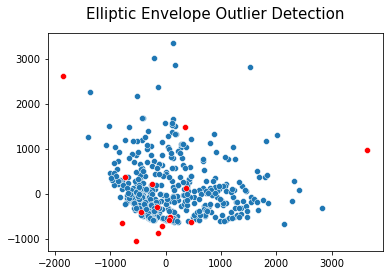

In [8]:
# Transformando em 2 dimensoes para plotar
pca = PCA(n_components=2)
text_sequences = textToSequence(df_course_clean['CONTEUDO_CLEAN'])
text_sequences_pca = pca.fit_transform(text_sequences)
outlier_values_pca = pca.fit_transform(outlier_values)

# Plotando outliers
sns.scatterplot(x=text_sequences_pca[:,0], y=text_sequences_pca[:,1])
sns.scatterplot(x=outlier_values_pca[:,0], 
                y=outlier_values_pca[:,1], color='r')
plt.title("Elliptic Envelope Outlier Detection", fontsize=15, pad=15)
#plt.savefig("Elliptic Envelope Detection.png", dpi=80)

In [9]:
# Registros considerados outliers
df_course_clean.iloc[outlier_index[0]]

,ID,DISCIPLINA,CONTEUDO,CONTEUDO_CLEAN
65,66,C1,• Entender e praticar os conceitos do uso de f...,entender praticar conceitos uso funções lingua...
296,297,C1,Hoje Aulas em ambiente Virtual- devido ao COVI...,hoje aulas ambiente virtual- devido covid : me...
555,556,C1,No período de 17/03 a 31/03- suspensão de aula...,no período 17/03 31/03- suspensão aula presenc...
600,601,C1,“A partir de 17/03- suspensão de aula presenci...,“ a partir 17/03- suspensão aula presencial- d...
714,715,C1,Introdução ao processamento de transações; Sis...,introdução processamento transações ; sistemas...
799,800,C1,Hoje Aulas em ambiente Virtual- devido ao COVI...,hoje aulas ambiente virtual- devido covid : py...
916,917,C1,“A partir de 17/03- suspensão de aula presenci...,“ a partir 17/03- suspensão aula presencial- d...
1163,1164,C1,Hoje Aulas em ambiente Virtual- devido ao COVI...,hoje aulas ambiente virtual- devido covid : te...
1220,1221,C1,Hoje Aulas em ambiente Virtual- devido ao COVI...,hoje aulas ambiente virtual- devido covid : av...
1731,1732,C1,Hoje Aulas em ambiente Virtual- devido ao COVI...,hoje aulas ambiente virtual- devido covid : pa...


In [10]:
# Dropando os registros considerados outliers e resetando index
df_course_clean = df_course_clean.drop(df_course_clean.iloc[outlier_index[0]].index)
df_course_clean.reset_index(drop=True, inplace=True)

In [11]:
# Extraindo 5 keywords do conteudo clean
df_course_clean['KEYWORDS'] = df_course_clean['CONTEUDO_CLEAN'].apply(lambda x: getKeywords(x,5))

In [12]:
df_course_clean

,ID,DISCIPLINA,CONTEUDO,CONTEUDO_CLEAN,KEYWORDS
0,1,C1,Apresentação da componente curricular ementas-...,apresentação componente curricular ementas- bi...,"[apresentação, componente, curricular, ementas..."
1,3,C1,Apresentação dos principais conceitos da lógic...,apresentação principais conceitos lógica progr...,"[apresentação, principais, conceitos, lógica, ..."
2,5,C1,Fluxogramas- introdução a psudolinguagem ativi...,fluxogramas- introdução psudolinguagem ativida...,"[fluxogramas-, introdução, psudolinguagem, ati..."
3,9,C1,Conceitos básicos para a construção de algorit...,conceitos básicos construção algoritmos comput...,"[conceitos, básicos, construção, algoritmos, c..."
4,13,C1,Descrição do funcionamento das estruturas de r...,descrição funcionamento estruturas repetição ....,"[descrição, funcionamento, demonstração, difer..."
...,...,...,...,...,...
555,2354,C3,Atividades práticas.,atividades práticas .,"[atividades, práticas, ]"
556,2356,C3,Avaliação teórico - prática,avaliação teórico prática,"[avaliação, teórico, prática]"
557,2360,C3,Término da avaliação prática,término avaliação prática,"[término, avaliação, prática]"
558,2364,C3,Introdução ao Maven; exemplos práticos.,introdução maven ; exemplos práticos .,"[introdução, maven, ;, exemplos, práticos]"


#### Clusterização

In [13]:
clusters, quiquadrado = getCluster(df_course_clean['CONTEUDO_CLEAN'])
df_course_clean['CLUSTER'] = pd.Series(clusters)

In [14]:
df_course_clean

,ID,DISCIPLINA,CONTEUDO,CONTEUDO_CLEAN,KEYWORDS,CLUSTER
0,1,C1,Apresentação da componente curricular ementas-...,apresentação componente curricular ementas- bi...,"[apresentação, componente, curricular, ementas...",2
1,3,C1,Apresentação dos principais conceitos da lógic...,apresentação principais conceitos lógica progr...,"[apresentação, principais, conceitos, lógica, ...",15
2,5,C1,Fluxogramas- introdução a psudolinguagem ativi...,fluxogramas- introdução psudolinguagem ativida...,"[fluxogramas-, introdução, psudolinguagem, ati...",12
3,9,C1,Conceitos básicos para a construção de algorit...,conceitos básicos construção algoritmos comput...,"[conceitos, básicos, construção, algoritmos, c...",10
4,13,C1,Descrição do funcionamento das estruturas de r...,descrição funcionamento estruturas repetição ....,"[descrição, funcionamento, demonstração, difer...",0
...,...,...,...,...,...,...
555,2354,C3,Atividades práticas.,atividades práticas .,"[atividades, práticas, ]",0
556,2356,C3,Avaliação teórico - prática,avaliação teórico prática,"[avaliação, teórico, prática]",1
557,2360,C3,Término da avaliação prática,término avaliação prática,"[término, avaliação, prática]",1
558,2364,C3,Introdução ao Maven; exemplos práticos.,introdução maven ; exemplos práticos .,"[introdução, maven, ;, exemplos, práticos]",7


In [16]:
df_closest_sample, df_farthest_sample = getClosestFarthest(df_course_clean,quiquadrado)

In [17]:
df_closest_sample.head()

,ID,DISCIPLINA,CONTEUDO,CONTEUDO_CLEAN,KEYWORDS,CLUSTER,qui-quadrado
302,1387,C1,Suspensão de aula presencial- devido ao plano ...,suspensão aula presencial- devido plano precau...,"[suspensão, aula, presencial-, devido, plano]",0,23.8403
80,427,C1,Atividade prática utilizando recursão. Aulas p...,atividade prática utilizar recursão . aulas pr...,"[atividade, prática, utilizar, recursão, aulas]",1,23.2546
389,1764,C1,Apresentação da disciplina- introdução a jorna...,apresentação disciplina- introdução jornada ap...,"[apresentação, disciplina-, introdução, jornad...",2,23.2864
180,893,C1,“A partir de 17/03- suspensão de aula presenci...,“ a partir 17/03- suspensão aula presencial- d...,"[“, partir, 17/03-, suspensão, aula]",3,22.3723
331,1501,C1,Atividades práticas no AVA - desenvolvimento d...,atividades práticas ava desenvolvimento conexã...,"[atividades, práticas, ava, desenvolvimento, c...",4,23.2195


In [18]:
df_farthest_sample.head()

,ID,DISCIPLINA,CONTEUDO,CONTEUDO_CLEAN,KEYWORDS,CLUSTER,qui-quadrado
23,126,C1,Protocolo Ethernet Address Resolution Protocol...,protocolo ethernet address resolution protocol...,"[protocolo, ethernet, address, resolution, pro...",0,25.3242
540,2304,C3,Tratamentos de erros na aplicação; avaliação t...,tratamentos erros aplicação ; avaliação teóric...,"[tratamentos, erros, aplicação, ;, avaliação]",1,24.7345
406,1829,C1,Aplicação das correções sugeridas durante a ba...,aplicação correções sugerir durante banca apre...,"[aplicação, correções, sugerir, durante, banca]",2,24.9480
190,942,C1,No período de 17/03 a 31/03- suspensão de aula...,no período 17/03 31/03- suspensão aula presenc...,"[no, período, 17/03, 31/03-, suspensão]",3,24.4120
457,2099,C3,Processamento de dados,processamento dar,"[processamento, dar]",4,24.6443


/home/tiago/anaconda3/envs/TestePocAvulsa/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/tiago/anaconda3/envs/TestePocAvulsa/lib/python3.9/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)
/home/tiago/anaconda3/envs/TestePocAvulsa/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinter

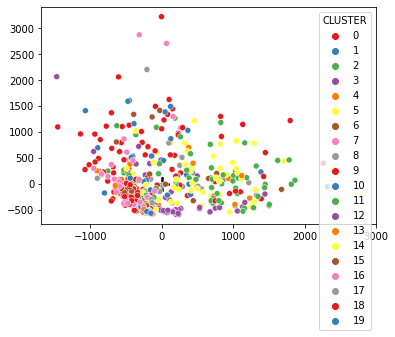

In [15]:
# plot the cluster centers and samples 
vectorizer = TfidfVectorizer(stop_words=stop_words)
text_vect = vectorizer.fit_transform(df_course_clean['CONTEUDO_CLEAN'])

kmeans = KMeans(n_clusters=20, random_state=0)
kmeans.fit(text_vect)
clusters = kmeans.labels_
text_sequences2 = textToSequence(df_course_clean['CONTEUDO_CLEAN'])
text_sequences_pca2 = pca.fit_transform(text_sequences2)
sns.scatterplot(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], 
                marker='+', 
                color='black', 
                s=200);
sns.scatterplot(text_sequences_pca2[:,0], text_sequences_pca2[:,1], hue=df_course_clean['CLUSTER'], 
                palette=sns.color_palette("Set1", n_colors=20));

<AxesSubplot:>

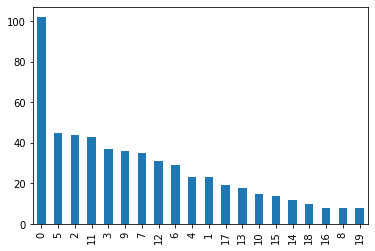

In [19]:
df_course_clean['CLUSTER'].value_counts().plot(kind='bar')

## Rodando o pipe

In [82]:
df_course = pd.read_csv('data/course.csv')
df_offers = pd.read_csv('data/offers.csv')

### Course

In [97]:
df_course_clean = fillNADropDuplicated(df_course,["DISCIPLINA","CONTEUDO"])
df_course_clean['CONTEUDO_CLEAN'] = df_course_clean['CONTEUDO'].apply(lambda x: preProcessingText(x))
outlier_index, outlier_values = getOutliers(df_course_clean.loc[:, 'CONTEUDO_CLEAN'])
# Dropando os registros considerados outliers e resetando index
df_course_clean = df_course_clean.drop(df_course_clean.iloc[outlier_index[0]].index)
df_course_clean.reset_index(drop=True, inplace=True)
# Extraindo 5 keywords do conteudo clean
df_course_clean['KEYWORDS'] = df_course_clean['CONTEUDO_CLEAN'].apply(lambda x: getKeywords(x,5))
clusters, quiquadrado = getCluster(df_course_clean['CONTEUDO_CLEAN'])
df_course_clean['CLUSTER'] = pd.Series(clusters)

In [98]:
df_course_clean

,ID,DISCIPLINA,CONTEUDO,CONTEUDO_CLEAN,KEYWORDS,CLUSTER
0,1,C1,Apresentação da componente curricular ementas-...,apresentação componente curricular ementas bib...,"[apresentação, componente, curricular, ementas...",7
1,3,C1,Apresentação dos principais conceitos da lógic...,apresentação principais conceitos lógica progr...,"[apresentação, principais, conceitos, lógica, ...",17
2,5,C1,Fluxogramas- introdução a psudolinguagem ativi...,fluxogramas introdução psudolinguagem atividad...,"[fluxogramas, introdução, psudolinguagem, ativ...",5
3,9,C1,Conceitos básicos para a construção de algorit...,conceitos básicos construção algoritmos comput...,"[conceitos, básicos, construção, algoritmos, c...",9
4,13,C1,Descrição do funcionamento das estruturas de r...,descrição funcionamento estruturas repetição ....,"[descrição, funcionamento, demonstração, difer...",0
...,...,...,...,...,...,...
555,2354,C3,Atividades práticas.,atividades práticas .,"[atividades, práticas, ]",5
556,2356,C3,Avaliação teórico - prática,avaliação teórico prática,"[avaliação, teórico, prática]",8
557,2360,C3,Término da avaliação prática,término avaliação prática,"[término, avaliação, prática]",8
558,2364,C3,Introdução ao Maven; exemplos práticos.,introdução maven ; exemplos práticos .,"[introdução, maven, ;, exemplos, práticos]",5


In [127]:
counts_course_keywords = getKeywordRank(df_course_clean['KEYWORDS'])
counts_course_keywords

[('devido', 107),
 ('ambiente', 106),
 ('hoje', 104),
 ('aulas', 104),
 ('virtual', 103),
 ('atividade', 45),
 ('suspensão', 41),
 ('introdução', 38),
 ('aula', 38),
 ('apresentação', 37),
 ('17/03', 37),
 ('jornada', 37),
 ('aprendizagem', 35),
 ('partir', 29),
 ('projeto', 26),
 ('conceitos', 21),
 ('dar', 21),
 ('revisão', 20),
 ('prática', 18),
 ('utilizar', 18),
 ('período', 18),
 ('exemplos', 18),
 ('atividades', 17),
 ('estruturas', 16),
 ('sobre', 16),
 ('31/03', 16),
 ('banco', 15),
 ('avaliativa', 14),
 ('no', 14),
 (')', 14),
 ('programação', 13),
 ('diagrama', 13),
 ('exercícios', 12),
 ('disciplina', 12),
 ('lógica', 11),
 ('funções', 11),
 ('(', 11),
 ('aplicação', 11),
 ('remota', 10),
 ('desenvolvimento', 10),
 ('criação', 10),
 ('práticas', 9),
 ('vetores', 9),
 ('conteúdo', 9),
 ('tecnologia', 9),
 ('estrutura', 9),
 ('variáveis', 9),
 ('correção', 9),
 ('curricular', 8),
 ('decisão', 8),
 ('uso', 8),
 ('resolução', 8),
 ('proposto', 8),
 ('java', 8),
 ('semestre', 8)

In [129]:
course_keywords_list = [k for k,v in counts_course_keywords]
course_keywords_list

['devido',
 'ambiente',
 'hoje',
 'aulas',
 'virtual',
 'atividade',
 'suspensão',
 'introdução',
 'aula',
 'apresentação',
 '17/03',
 'jornada',
 'aprendizagem',
 'partir',
 'projeto',
 'conceitos',
 'dar',
 'revisão',
 'prática',
 'utilizar',
 'período',
 'exemplos',
 'atividades',
 'estruturas',
 'sobre',
 '31/03',
 'banco',
 'avaliativa',
 'no',
 ')',
 'programação',
 'diagrama',
 'exercícios',
 'disciplina',
 'lógica',
 'funções',
 '(',
 'aplicação',
 'remota',
 'desenvolvimento',
 'criação',
 'práticas',
 'vetores',
 'conteúdo',
 'tecnologia',
 'estrutura',
 'variáveis',
 'correção',
 'curricular',
 'decisão',
 'uso',
 'resolução',
 'proposto',
 'java',
 'semestre',
 'controle',
 'crud',
 'javascript',
 'práticos',
 'componente',
 'avaliação',
 'linguagem',
 'semana',
 'definição',
 'modelo',
 'requisito',
 'react',
 'native',
 'constantes',
 'matrizes',
 'entender',
 'software',
 'motivo',
 'ava',
 'conceito',
 'modelagem',
 'arquivos',
 'tipos',
 'plano',
 'css',
 'projetos',
 

### Offers

In [99]:
df_offers_clean = fillNADropDuplicated(df_offers,["TITLE","VALORDESCRIPTION"])
df_offers_clean['VALORDESCRIPTION_CLEAN'] = df_offers_clean['VALORDESCRIPTION'].apply(lambda x: preProcessingText(x))
outlier_index, outlier_values = getOutliers(df_offers_clean.loc[:, 'VALORDESCRIPTION_CLEAN'])
# Dropando os registros considerados outliers e resetando index
df_offers_clean = df_offers_clean.drop(df_offers_clean.iloc[outlier_index[0]].index)
df_offers_clean.reset_index(drop=True, inplace=True)
# Extraindo 5 keywords do conteudo clean
df_offers_clean['KEYWORDS'] = df_offers_clean['VALORDESCRIPTION_CLEAN'].apply(lambda x: getKeywords(x,5))
clusters, quiquadrado = getCluster(df_offers_clean['VALORDESCRIPTION_CLEAN'])
df_offers_clean['CLUSTER'] = pd.Series(clusters)

In [100]:
df_offers_clean

,ID,TITLE,VALORDESCRIPTION,VALORDESCRIPTION_CLEAN,KEYWORDS,CLUSTER
0,1,Analista de Google Ads,Para o cargo de Analista em Google Ads precisa...,para cargo analista google ads precisar pessoa...,"[auxiliar, anúncios, pesquisa, analista, preci...",8
1,2,Técnico de Suporte/programação - Ti,Descrição\n• Realizar manutenção e desenvolvim...,descrição realizar manutenção desenvolvimento ...,"[realizar, banco, serviços, experiência, descr...",6
2,3,Desenvolvedor C++,Desenvolvimento de sistemas embarcados- integr...,desenvolvimento sistemas embarcar integração h...,"[módulos, embarcar, integração, hardware, jogos]",4
3,4,Analista Programador,Atuar com participação em projetos- programaçã...,atuar participação projetos programação anális...,"[atuar, participação, projetos, implantação, m...",4
4,5,Analista De Sistema (Programação Web),- Desenvolver sistemas em interface Web;\n- Re...,desenvolver sistemas interface web ; realizar ...,"[desenvolver, sistemas, interface, web, ;]",19
...,...,...,...,...,...,...
92,94,Desenvolvedor de Back-End,Desenvolvedor de Back-End -- Descrição Realiza...,desenvolvedor backend descrição realizar aju...,"[conhecimento, básico, backend, descrição, rea...",0
93,95,Back End Developer (.NET/ASP.NET),Vamos transformar o Brasil em uma sociedade ma...,vamos transformar brasil sociedade digital col...,"[saúde, soluções, código, ajudar, 100]",16
94,98,Desenvolvedor Backend Mobile & Web,Estamos em busca de um(a) Desenvolvedor Backen...,estamos busca um(a ) desenvolvedor backend mob...,"[busca, um(a, desenvolvedor, backend, o(a]",0
95,99,Desenvolvedor(a) Back-end Ruby Pleno,Estamos em busca de um(a) Desenvolvedor(a) Rub...,estamos busca um(a ) desenvolvedor(a ) ruby ju...,"[experiência, ruby, ajudar, um(a, desenvolvedo...",16


In [130]:
counts_offer_keywords = getKeywordRank(df_offers_clean['KEYWORDS'])
counts_offer_keywords

[('descrição', 15),
 ('programação', 14),
 ('experiência', 12),
 ('área', 9),
 ('desenvolvimento', 9),
 ('conhecimento', 9),
 ('informática', 8),
 ('realizar', 7),
 ('software', 7),
 ('atividades', 7),
 ('estar', 5),
 ('analista', 4),
 ('projetos', 4),
 ('web', 4),
 ('manutenção', 4),
 ('cursar', 4),
 ('geral', 4),
 ('ti', 4),
 ('desenvolvedor', 4),
 ('empresa', 4),
 ('código', 4),
 ('instalação', 4),
 ('profissional', 4),
 ('hardware', 3),
 ('atuar', 3),
 ('sistemas', 3),
 ('mecânica', 3),
 ('técnico', 3),
 ('olá', 3),
 ('ensino', 3),
 ('trabalho', 3),
 ('plataforma', 3),
 ('compartilhar', 3),
 ('colocar', 3),
 ('relação', 3),
 ('especialização', 3),
 ('r$', 3),
 ('informático', 3),
 ('desenvolvedor(a', 3),
 ('auxiliar', 2),
 ('serviços', 2),
 ('desenvolver', 2),
 ('curso', 2),
 ('javascript', 2),
 ('saúde', 2),
 ('coordenador', 2),
 ('nível', 2),
 ('instrutor(a', 2),
 ('serem', 2),
 ('dever', 2),
 ('java', 2),
 ('conhecimentos', 2),
 ('cliente', 2),
 ('linguagem', 2),
 ('necessário',

In [131]:
offer_keywords_list = [k for k,v in counts_offer_keywords]
offer_keywords_list

['descrição',
 'programação',
 'experiência',
 'área',
 'desenvolvimento',
 'conhecimento',
 'informática',
 'realizar',
 'software',
 'atividades',
 'estar',
 'analista',
 'projetos',
 'web',
 'manutenção',
 'cursar',
 'geral',
 'ti',
 'desenvolvedor',
 'empresa',
 'código',
 'instalação',
 'profissional',
 'hardware',
 'atuar',
 'sistemas',
 'mecânica',
 'técnico',
 'olá',
 'ensino',
 'trabalho',
 'plataforma',
 'compartilhar',
 'colocar',
 'relação',
 'especialização',
 'r$',
 'informático',
 'desenvolvedor(a',
 'auxiliar',
 'serviços',
 'desenvolver',
 'curso',
 'javascript',
 'saúde',
 'coordenador',
 'nível',
 'instrutor(a',
 'serem',
 'dever',
 'java',
 'conhecimentos',
 'cliente',
 'linguagem',
 'necessário',
 'requisitos',
 'tecnologia',
 'práticas',
 'vaga',
 'interedes',
 'empresasuperprof',
 'habilidades',
 'preferência',
 '1',
 'ser',
 'câmeras',
 'boa',
 'tarde',
 'manhã',
 'solicitar',
 'detalhar',
 'acontecer',
 'brasil',
 'atuará',
 'pleno',
 'computadores',
 'limpeza'

### Comparando keywords dos dois conjuntos de dados

In [132]:
set(course_keywords_list) & set(offer_keywords_list)

{')',
 '1',
 'ajudar',
 'aplicações',
 'atividades',
 'através',
 'avaliação',
 'backend',
 'banco',
 'brasil',
 'busca',
 'básico',
 'computadores',
 'configuração',
 'conhecimentos',
 'controle',
 'criação',
 'descrição',
 'desenvolver',
 'desenvolvido',
 'desenvolvimento',
 'engenharia',
 'ensino',
 'especificação',
 'estágio',
 'formatar',
 'formação',
 'função',
 'geral',
 'gerenciamento',
 'integração',
 'interface',
 'java',
 'javascript',
 'linguagem',
 'melhorias',
 'montagem',
 'mysql',
 'organização',
 'pesquisa',
 'php',
 'planejamento',
 'principais',
 'profissional',
 'programador',
 'programação',
 'projetos',
 'práticas',
 'realizar',
 'requisitos',
 'saber',
 'sistema',
 'sistemas',
 'software',
 'softwares',
 'solução',
 'sql',
 'tecnologia',
 'ter',
 'trabalhar',
 'trabalho',
 'usuários',
 'utilizar',
 'web'}